In [1]:
import pandas as pd 
import pymc as pm
import arviz as az
import numpy as np

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
import palmerpenguins as pp

In [10]:
penguins = pp.load_penguins()

In [13]:
missing_data = penguins.isnull()[["bill_length_mm", "flipper_length_mm", "sex", "body_mass_g"]].any(axis=1)
penguins = penguins.loc[~missing_data]

In [14]:
summary_stats = (penguins.loc[:, ["species", "body_mass_g"]].groupby("species").agg(["mean", "std", "count"]))

In [15]:
summary_stats

body_mass_g                  
                  mean         std count
species                                 
Adelie     3706.164384  458.620135   146
Chinstrap  3733.088235  384.335081    68
Gentoo     5092.436975  501.476154   119

In [20]:
adelie_mask = (penguins["species"] == "Adelie")
adelie_mask_obs = penguins.loc[adelie_mask, "body_mass_g"].values

In [24]:
with pm.Model() as model_adelie_penguins_mass:
 sigma = pm.HalfStudentT("sigma", 100, 2000)
 mu = pm.Normal("mu", 4000, 3000)
 mass = pm.Normal("mass", mu=mu, sigma=sigma, observed=adelie_mask_obs)

 idata = pm.sample_prior_predictive(samples= 5000)
 idata.extend(pm.sample(chains= 4, return_inferencedata= True))

Sampling: [mass, mu, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


In [25]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

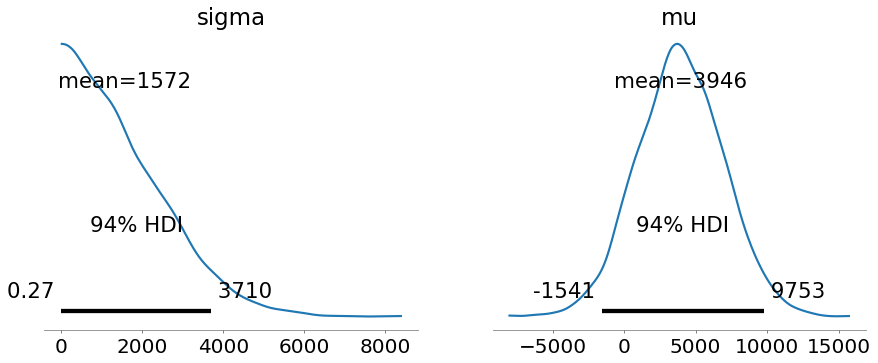

In [26]:
axes = az.plot_posterior(idata.prior, var_names=["sigma", "mu"], textsize=20)

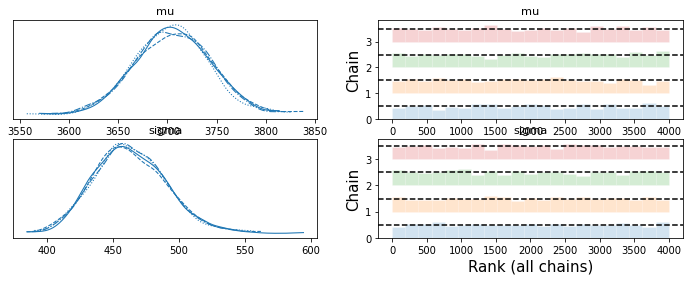

In [31]:
axes = az.plot_trace(idata, divergences= "bottom", kind="rank_bars")

In [32]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,3705.642,38.517,3629.926,3774.512,0.586,0.414,4330.0,2700.0,1.0
sigma,463.052,27.246,413.325,514.507,0.415,0.295,4366.0,3129.0,1.0


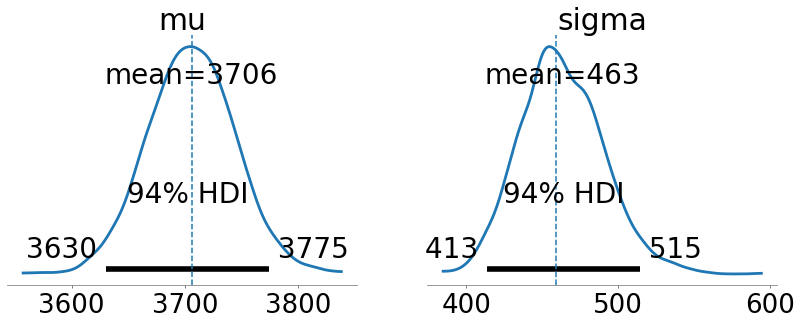

In [33]:
axes = az.plot_posterior(idata, hdi_prob=.94, textsize=26);

axes[0].axvline(3706, linestyle="--")
axes[1].axvline(459, linestyle="--")

In [34]:
all_species = pd.Categorical(penguins["species"])

In [39]:
with pm.Model() as model_penguin_mass_all_species:
 sigma = pm.HalfStudentT("sigma", 100, 2000, shape= 3)
 mu = pm.Normal("mu", 4000, 3000, shape= 3)
 mass = pm.Normal("mass", mu=mu[all_species.codes], sigma=sigma[all_species.codes], observed=penguins["body_mass_g"])

 idata = pm.sample(return_inferencedata= True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


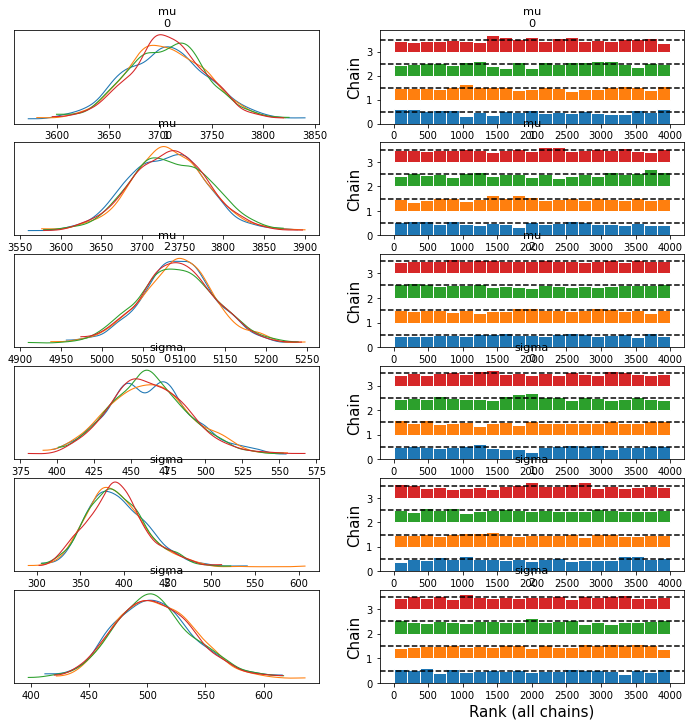

In [41]:
axes = az.plot_trace(idata, divergences="bottom", kind="rank_bars", compact=False)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

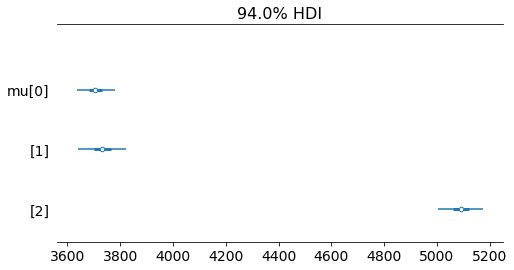

In [44]:
az.plot_forest(idata, var_names=["mu"], combined=True, hdi_prob=.94, figsize=(8, 4))

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

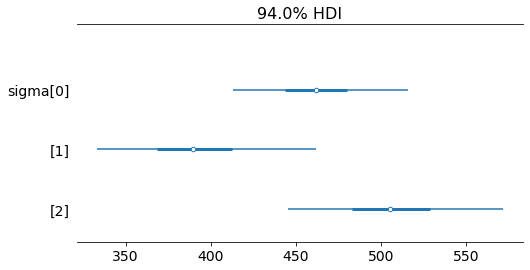

In [45]:
az.plot_forest(idata, var_names=["sigma"], combined=True, hdi_prob=.94, figsize=(8, 4))

In [5]:
import tensorflow as tf
import tensorflow_probability as tfp

ImportError: This version of TensorFlow Probability requires TensorFlow version >= 2.15; Detected an installation of version 2.12.0. Please upgrade TensorFlow to proceed.

In [ ]:
tfd = tfd.distribuions
root = tfd.JointDistributionCoroutine.Root

In [ ]:
species_idx = tf.constant(all_species.codes, dtype=tf.int32) 
body_mass_g = tf.constant(penguins["body_mass_g"].values, dtype=tf.float32)

In [ ]:
@tfd.JointDistributionCoroutine
def jd_penguin_mass_all_species():
    σ = yield root(tfd.Sample(
            tfd.HalfStudentT(df=100, loc=0, scale=2000),
            sample_shape=3,
            name="sigma"))
    μ = yield root(tfd.Sample(
            tfd.Normal(loc=4000, scale=3000),
            sample_shape=3,
            name="mu"))
    mass = yield tfd.Independent(
        tfd.Normal(loc=tf.gather(μ, species_idx, axis=-1),
                   scale=tf.gather(σ, species_idx, axis=-1)),
        reinterpreted_batch_ndims=1,
        name="mass")